# Question Q15 - Distribution

*Question*: Based on your experience, what percentage of the ML-enabled system projects that get deployed into production have their ML models actually being monitored?

*Answer Type*: Numerical

### Necessary Libraries

In [1]:
import pandas as pd
from utils.basic import rename_values
from utils.dataframe import DataframeUtils
from utils.plot import PlotUtils
from utils.bootstrapping import BootstrappingUtils

### Dataframe Init

In [2]:
dataframe_obj = DataframeUtils('./data/main_data.csv', ';', './data/unused_columns.txt', './data/formatted_columns.txt')
# the index is not important, but when we internally format df we need to reset index
dataframe_obj.df = dataframe_obj.df.reset_index(drop=True)

In this research, we conservatively considered those who fully completed the survey. So, we discarded suspended submissions.

In [3]:
dataframe_obj.df.drop(dataframe_obj.df[dataframe_obj.df['Status'] == 'Suspended (22)'].index, inplace = True)

### Basic Analysis

In [4]:
dataframe_obj.df['Q15_Model_Deploy_Production_Monitoring'].head()

0    -77
1     70
2     60
3    100
4     80
Name: Q15_Model_Deploy_Production_Monitoring, dtype: object

In [5]:
# cleaning data
dataframe_obj.remove_value_from_df('-77','Q15_Model_Deploy_Production_Monitoring')

In [6]:
# convert column to integer - if you read before this line, you will get an string like '14'
dataframe_obj.df = dataframe_obj.df.astype({"Q15_Model_Deploy_Production_Monitoring": int}, errors='raise') 

In [7]:
# ranges that interest us
monitoring_ranges = {
    '0 - 20%': {
        'lower_bound': 0,
        'upper_bound': 20, # goes until 20 (not included),
        'position': 5,
    },
    '20% - 40%': {
        'lower_bound': 20,
        'upper_bound': 40, # goes until 40 (not included)
        'position': 4,
    },
    '40% - 60%': {
        'lower_bound': 40,
        'upper_bound': 60, # goes until 60 (not included)
        'position': 3,
    },
    '60% - 80%': {
        'lower_bound': 60,
        'upper_bound': 80, # goes until 80 (not included)
        'position': 2,
    },
    '80% - 100%': {
        'lower_bound': 80,
        'upper_bound': 101, # goes until 100 (included)
        'position': 1,
    }
}

In [8]:
indexes = []
values = []
chart_positions = []
position = 0
for monitoring_range in monitoring_ranges:
    indexes.append(monitoring_range)
    total_projects_monitored_in_range = len(dataframe_obj.df[ 
                                               (dataframe_obj.df['Q15_Model_Deploy_Production_Monitoring'] >= monitoring_ranges[monitoring_range]['lower_bound']) & 
                                               (dataframe_obj.df['Q15_Model_Deploy_Production_Monitoring'] < monitoring_ranges[monitoring_range]['upper_bound'])
                                           ])
    values.append(total_projects_monitored_in_range)
    chart_positions.append(monitoring_ranges[monitoring_range]['position'])

In [9]:
# plot object
q15_plot = PlotUtils(pd.DataFrame(
    data={'Projects in Production Monitored': indexes, 'Answers': values, 'Chart Position': chart_positions}
).sort_values(by=['Chart Position', 'Answers'], ascending=False))

In [10]:
q15_plot.df

,Projects in Production Monitored,Answers,Chart Position
0,0 - 20%,53,5
1,20% - 40%,34,4
2,40% - 60%,30,3
3,60% - 80%,13,2
4,80% - 100%,31,1


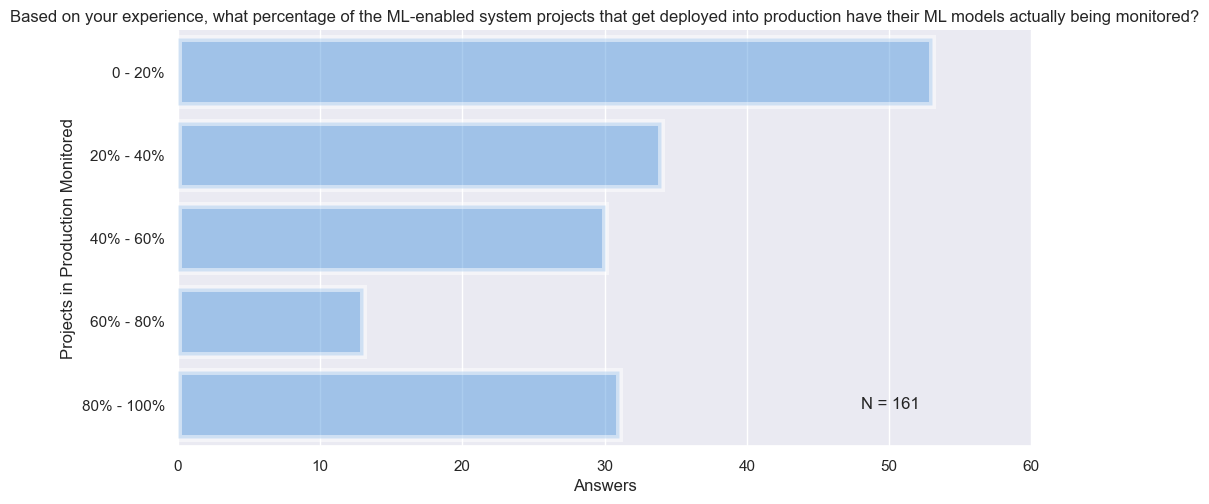

In [11]:
# compute total of answer considered in this question
total_answers = "N = " + str(len(dataframe_obj.df['Q15_Model_Deploy_Production_Monitoring']))
total_answers_int = len(dataframe_obj.df['Q15_Model_Deploy_Production_Monitoring'])

q15_plot.single_barplot(x_axis="Answers", y_axis="Projects in Production Monitored",
                       title="Based on your experience, what percentage of the ML-enabled system projects that get deployed into production have their ML models actually being monitored?",
                       x_label="Answers", y_label="Projects in Production Monitored", x_label_rotation=0, color="#429bf5", total_answers=total_answers)

### Bootstrapping Analysis

In [12]:
valid_options_list = list(monitoring_ranges.keys())

In [13]:
valid_answers_list_temp = list(dataframe_obj.df['Q15_Model_Deploy_Production_Monitoring'])

In [14]:
valid_answers_list = []
for valid_answer in valid_answers_list_temp:
    for monitoring_range in monitoring_ranges:
        if (valid_answer >= monitoring_ranges[monitoring_range]['lower_bound']) and (valid_answer < monitoring_ranges[monitoring_range]['upper_bound']):
            valid_answers_list.append(monitoring_range)
            break

In [15]:
replacements = 1000
population_sample_size = total_answers_int # equals n - total valid answers

bootstrapping_obj = BootstrappingUtils(valid_answers_list, valid_options_list, replacements, population_sample_size, 95)

In [16]:
bootstrapped_dict_data = bootstrapping_obj.bootstrapping('single')

In [17]:
# get a pair of values between dict key and all the list values inside that key 
# key: [val_1, val_2] ---> [(key, val_1), (key, val_2)...]
indexes = []
values = []
chart_positions = []
for idx in bootstrapped_dict_data:
    indexes += [idx for _ in range(len(bootstrapped_dict_data[idx]['population']))]
    values += bootstrapped_dict_data[idx]['population']
    chart_positions += [monitoring_ranges[idx]['position'] for _ in range(len(bootstrapped_dict_data[idx]['population']))]

In [18]:
values = [100 * v for v in values]

In [19]:
# plot object for bootstrapped data
q15_boot_plot = PlotUtils(pd.DataFrame(
    data={'Model Deploy Production Monitoring': indexes, 'Value': values, 'Chart Position': chart_positions}
).sort_values(by=['Chart Position'], ascending=False))

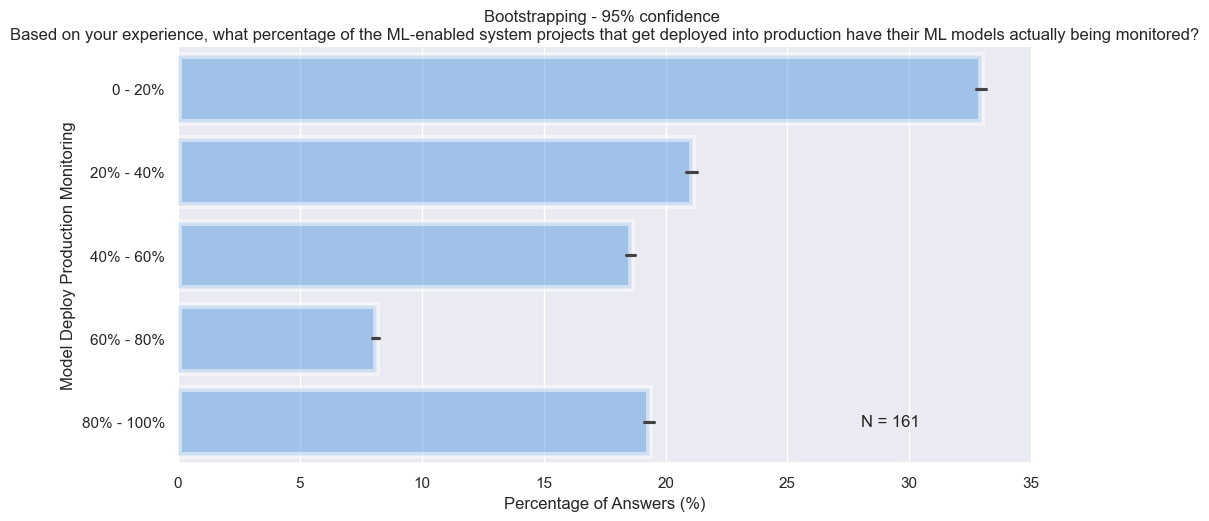

In [20]:
q15_boot_plot.single_barplot(x_axis="Value", y_axis="Model Deploy Production Monitoring", 
                       title="Bootstrapping - 95% confidence \nBased on your experience, what percentage of the ML-enabled system projects that get deployed into production have their ML models actually being monitored?",
                       x_label="Percentage of Answers (%)", y_label="Model Deploy Production Monitoring", x_label_rotation=0, color="#429bf5", 
                       total_answers=total_answers)

In [21]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':' + str(bootstrapped_dict_data[idx]['confidence']))

Option: (Lower Value, Mean, Upper Value)
0 - 20%:(0.32715108646601815, 0.32931055900621115, 0.33147003154640414)
20% - 40%:(0.20861428937654275, 0.21072049689440994, 0.21282670441227713)
40% - 60%:(0.18382714749308465, 0.18572049689440995, 0.18761384629573524)
60% - 80%:(0.0796881196772383, 0.08104347826086955, 0.0823988368445008)
80% - 100%:(0.19127370163942556, 0.1932049689440994, 0.19513623624877321)


In [22]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':: P = ' + str(round((bootstrapped_dict_data[idx]['confidence'][1] * 100), 3)) + " [" + str(round((bootstrapped_dict_data[idx]['confidence'][0] * 100), 3)) + ", " + str(round((bootstrapped_dict_data[idx]['confidence'][2] * 100), 3)) + "]")

Option: (Lower Value, Mean, Upper Value)
0 - 20%:: P = 32.931 [32.715, 33.147]
20% - 40%:: P = 21.072 [20.861, 21.283]
40% - 60%:: P = 18.572 [18.383, 18.761]
60% - 80%:: P = 8.104 [7.969, 8.24]
80% - 100%:: P = 19.32 [19.127, 19.514]
